<a href="https://colab.research.google.com/github/duckwarrior103/Transformers/blob/main/BabyTransformerBlock_Kyan_Sorting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Writing a simple transformer block with PyTorch Libraries

The transformer is defined as follows:

$$
\begin{aligned}
\hat{\mathbf{Y}} &= \text{Transformer}(\mathbf{X}) \\
&= \mathbf{X}
   + \Big[ \big(
       \text{softmax}\!\big(
           \frac{\mathbf{X}\mathbf{W}_q (\mathbf{X}\mathbf{W}_k)^{\top}}{\sqrt{n}}
       \big) \mathbf{X} \mathbf{W}_v \big) \mathbf{W}_1 + \mathbf{B}_1 \Big] \\
&\quad + \text{ReLU}\Bigg[
       \Big( \big(
           \text{softmax}\!\big(
               \frac{\mathbf{X}\mathbf{W}_q (\mathbf{X}\mathbf{W}_k)^{\top}}{\sqrt{n}}
           \big) \mathbf{X}\mathbf{W}_v \big) \mathbf{W}_1 + \mathbf{B}_1 \Big)
       \mathbf{W}_2 + \mathbf{B}_2 \Bigg] \mathbf{W}_3 + \mathbf{B}_3
\end{aligned}
$$

$$
\hat{\mathbf{Y}} \in \mathbb{R}^{m \times n}, \quad
\mathbf{X} \in \mathbb{R}^{m \times n}, \quad
\mathbf{W}_q, \mathbf{W}_k \in \mathbb{R}^{n \times d_k}, \quad
\mathbf{W}_v \in \mathbb{R}^{n \times d_v},
$$

$$
\mathbf{W}_1 \in \mathbb{R}^{d_v \times n}, \quad
\mathbf{W}_2 \in \mathbb{R}^{n \times d_\text{ff}}, \quad
\mathbf{W}_3 \in \mathbb{R}^{d_\text{ff} \times n}, \quad
\mathbf{B}_1 \in \mathbb{R}^{m \times n}, \quad
\mathbf{B}_2 \in \mathbb{R}^{m \times d_\text{ff}}, \quad
\mathbf{B}_3 \in \mathbb{R}^{m \times n}.
$$

$$
d_\text{ff},\, d_k,\, d_v,\, m,\, n \in \mathbb{Z}_{>0}.
$$


In [ ]:
!pip install torch

### Import libraries and check if GPU is available


In [ ]:
# Don't forget to do your imports!!!
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(torch.cuda.is_available())

True


### Self Attention Layer

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, n, d_k, d_v):
        super().__init__()
        self.n = n
        self.d_k = d_k
        self.W_k = nn.Linear(n, d_k)
        self.W_q = nn.Linear(n, d_k)
        self.W_v = nn.Linear(n, d_v)
        self.softmax = nn.Softmax(dim=-1)
        self.output_linear = nn.Linear(d_v, n)

    def forward(self, X):
        K = self.W_k(X)
        Q = self.W_q(X)
        V = self.W_v(X)
        attention_scores = torch.bmm(Q, K.transpose(1, 2)) / np.sqrt(self.d_k)
        probs = self.softmax(attention_scores)
        attention_output = torch.bmm(probs, V)
        # Pass the output through the linear layer
        return self.output_linear(attention_output)


### MLP Layer

In [ ]:
# Coding the MLP Block

class MLP(nn.Module):
    def __init__(self, n, d_ff):
        super().__init__()
        self.n = n
        self.layer1 = nn.Linear(n, d_ff)
        self.layer2 = nn.Linear(d_ff, n)
        self.relu = nn.ReLU()

    def forward(self, X):
        X = self.layer1(X)
        X = self.relu(X)
        X = self.layer2(X)
        return X

### Transformer
This puts together self-attention and MLP layers with a residual connection in each layer.

In [ ]:
class BabyTransformer(nn.Module):

  def __init__(self, m, n):
    super().__init__()
    self.criterion = nn.MSELoss()

    self.attention = SelfAttention(n, d_k=20, d_v=20)
    self.mlp = MLP(n, d_ff=100)
    self.optimizer = optim.Adam(self.parameters(), lr=0.001)
    self.epoch_history = []
    self.loss_history = []
    self.val_loss_history = []


  def forward(self, X_0):
        X_0 = X_0.float() # Convert input to float
        X_1 = X_0 + self.attention(X_0)
        X_2 = X_1 + self.mlp(X_1)
        Y_pred = X_2
        return Y_pred

  def train_model(self, X_train, Y_train, X_val, Y_val, epochs=500, patience=40, tol=1e-5, verbose=True):

        for epoch in range(epochs):
            # Training step
            self.train() # Set the model to training mode
            outputs = self.forward(X_train)
            loss = self.criterion(outputs, Y_train.float()) # Convert target to float

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Store epoch and training loss
            self.epoch_history.append(epoch + 1)
            self.loss_history.append(loss.item())

            # Validation step
            self.eval() # Set the model to evaluation mode
            with torch.no_grad(): # Disable gradient calculation for validation
                val_outputs = self.forward(X_val)
                val_loss = self.criterion(val_outputs, Y_val.float())

            # Store validation loss
            self.val_loss_history.append(val_loss.item())


            if verbose and (epoch + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.6f}, Validation Loss: {val_loss.item():.6f}")

        self.plot_loss()

  def test_model(self, X_test, Y_test):
        self.eval() # Set the model to evaluation mode
        with torch.no_grad(): # Disable gradient calculation for testing
            test_outputs = self.forward(X_test)
            test_loss = self.criterion(test_outputs, Y_test.float())
        test_loss = test_loss.item()
        print(f"Test loss is: {test_loss}")


  def plot_loss(self):
    epochs = np.array(self.epoch_history)
    train_losses = np.array(self.loss_history)
    val_losses = np.array(self.val_loss_history)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')

    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.title('Training and Validation Loss Curves (log scale)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

### Creating our data for training and validation

In [ ]:
# Define dimension of input m x n and batch size
m, n = 2, 2
batch_size = 100000

X = torch.randint(0, 50, (batch_size, m, n)) # Generate integer data
Y = torch.sort(X, dim=2).values # Sort by row

print("Original X (first 2 rows):\n", X[:2])
print("\nY Hat (first 2 rows):\n", Y[:2])
print(X.shape)

Original X (first 2 rows):
 tensor([[[33, 41],
         [38, 31]],

        [[27, 47],
         [42, 11]]], device='cuda:0')

Y Hat (first 2 rows):
 tensor([[[33, 41],
         [31, 38]],

        [[27, 47],
         [11, 42]]], device='cuda:0')
torch.Size([100000, 2, 2])


In [ ]:
# Split the data into training, validation, and test sets
validation_split_ratio = 0.2
test_split_ratio = 0.1 # Define the test split ratio
total_size = batch_size
test_size = int(total_size * test_split_ratio)
validation_size = int(total_size * validation_split_ratio)


X_test = X[:test_size]
Y_test = Y[:test_size]

X_val = X[test_size:test_size + validation_size]
Y_val = Y[test_size:test_size + validation_size]

X_train = X[test_size + validation_size:]
Y_train = Y[test_size + validation_size:]


print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_val:", Y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)

Shape of X_train: torch.Size([70000, 2, 2])
Shape of Y_train: torch.Size([70000, 2, 2])
Shape of X_val: torch.Size([20000, 2, 2])
Shape of Y_val: torch.Size([20000, 2, 2])
Shape of X_test: torch.Size([10000, 2, 2])
Shape of Y_test: torch.Size([10000, 2, 2])


### Initialise our transformer

In [ ]:
transformer = BabyTransformer(m, n)

### Training our transformer

Epoch [50/10000], Training Loss: 47.916351, Validation Loss: 47.122337
Epoch [100/10000], Training Loss: 21.328081, Validation Loss: 20.904797
Epoch [150/10000], Training Loss: 9.022189, Validation Loss: 8.791077
Epoch [200/10000], Training Loss: 4.732712, Validation Loss: 4.602218
Epoch [250/10000], Training Loss: 2.744657, Validation Loss: 2.644043
Epoch [300/10000], Training Loss: 1.590363, Validation Loss: 1.532761
Epoch [350/10000], Training Loss: 0.902910, Validation Loss: 0.873188
Epoch [400/10000], Training Loss: 0.524622, Validation Loss: 0.508843
Epoch [450/10000], Training Loss: 0.327040, Validation Loss: 0.319056
Epoch [500/10000], Training Loss: 0.223876, Validation Loss: 0.220207
Epoch [550/10000], Training Loss: 0.167456, Validation Loss: 0.165676
Epoch [600/10000], Training Loss: 0.133505, Validation Loss: 0.132633
Epoch [650/10000], Training Loss: 0.110960, Validation Loss: 0.110506
Epoch [700/10000], Training Loss: 0.094497, Validation Loss: 0.094305
Epoch [750/10000]

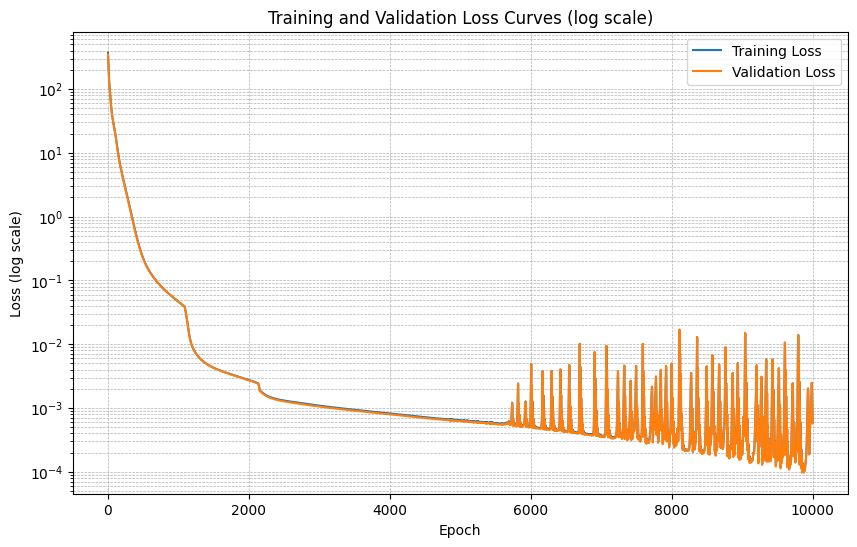

In [ ]:
transformer.train_model(X_train, Y_train, X_val, Y_val, epochs=10000, verbose=True)

### Inference with one random generated input matrix

In [ ]:
with torch.no_grad():
    # Generate a random m x n integer tensor
    test_input = torch.randint(0, 50, (1, m, n)).float() # Generate random 2x2 integer tensor and convert to float

    # Calculate the expected sorted output by row
    expected_output = torch.sort(test_input, dim=2).values

    # Get the model's prediction
    # Assuming the transformer model is defined and expects float input
    pred = transformer(test_input).round() # Pass float to the model and round the output for integer comparison

    # Format input
    input_str = "\n".join([str(row) for row in test_input[0]])
    print("Input:\n", input_str)

    # Format expected output
    expected_str = "\n".join([str(row) for row in expected_output[0]])
    print("\nExpected:\n", expected_str)

    # Format prediction
    pred_str = "\n".join([str(row) for row in pred[0]])
    print("\nPrediction:\n", pred_str)

Input:
 tensor([35.,  6.], device='cuda:0')
tensor([38.,  5.], device='cuda:0')

Expected:
 tensor([ 6., 35.], device='cuda:0')
tensor([ 5., 38.], device='cuda:0')

Prediction:
 tensor([ 6., 35.], device='cuda:0')
tensor([ 5., 38.], device='cuda:0')


### Running on test data set

In [ ]:
transformer.test_model(X_test, Y_test)

Test loss is: 0.0005909057217650115


0.0005909057217650115